In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
import Our_Qiskit_Functions as oq
from qiskit.extensions import UnitaryGate
import matplotlib
import matplotlib.pyplot as plt

import math as m
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import NearestNeighbors

S_simulator = Aer.backends(name='statevector_simulator')[0]

# 此处是一个jupyter notebook的魔术命令，用于在Notebook中启用交互式的Matplotlib绘图
%matplotlib notebook

# 设置Matplotlib的全局参数，将动画的渲染方式设置为JavaScript HTML。
plt.rcParams['animation.html'] = 'jshtml'

<IPython.core.display.Javascript object>


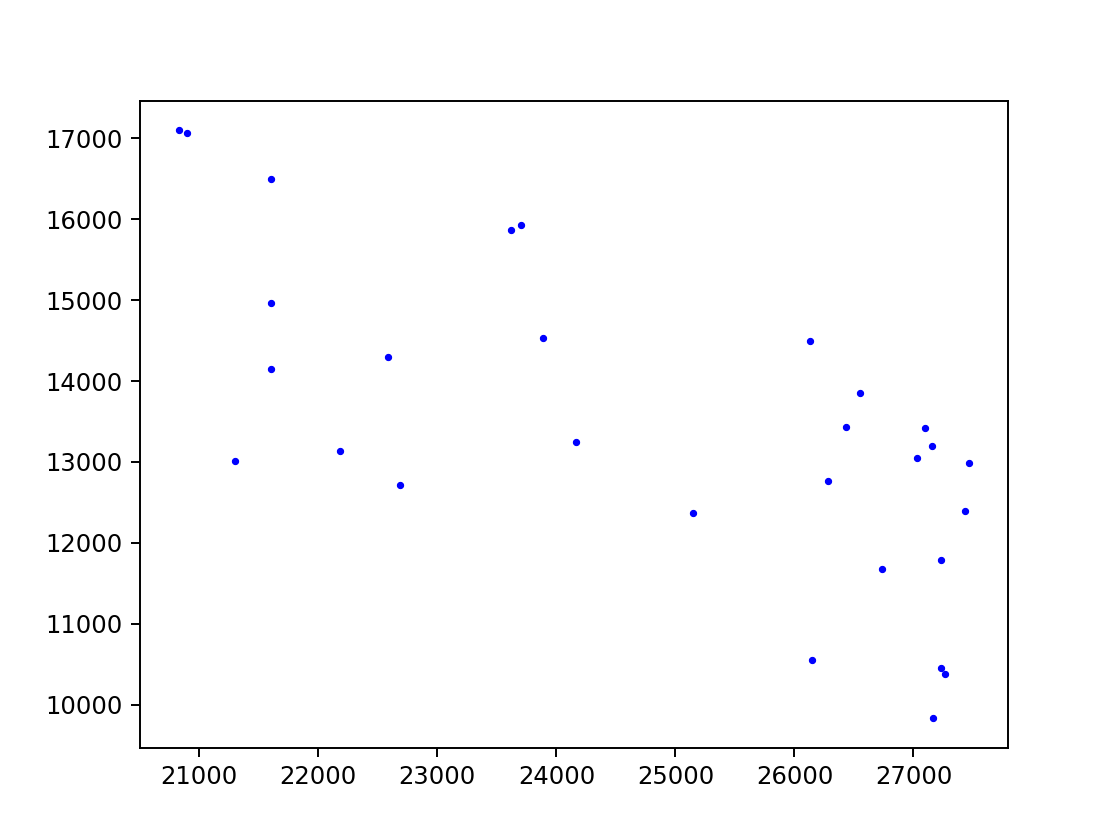

In [2]:
""" 导入数据 """

file_path = r'C:\Users\Lenovo\Desktop\TSP-Solution\dataset\wi29.tsp'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines = lines[7: -1]
points = list()
for line in lines:
    tmp_point = line.strip().split(' ')
    tmp_point = [float(x) for x in tmp_point]
    tmp_point[0] = int(tmp_point[0])
    points.append([tmp_point[1], tmp_point[2]])
    
point_num = len(points)
    
x_values = [points[i][0] for i in range(len(points))]
y_values = [points[i][1] for i in range(len(points))]
plt.scatter(x_values, y_values, marker='o', color='b', s=4)
plt.show()

In [3]:
""" 计算邻接矩阵 """

# 高斯径向基函数映射
def gussian_adjacency_reflect(adj_matrix):
    min_element = adj_matrix.min()
    max_element = adj_matrix.max()
    sigma = (max_element - min_element) * 0.15
    
    adj_reflect = np.zeros((point_num, point_num))
    for i in range(point_num):
        for j in range(point_num):
            if adj_matrix[i][j] != 0.0:
                adj_reflect[i][j] = np.exp(-np.square(np.array(adj_matrix[i][j]) / sigma)/2)
    return adj_reflect


def compute_adjacency_matrix(points, k_neighbors=5):
    nn = NearestNeighbors(n_neighbors=k_neighbors)
    adj_matrix = nn.fit(points).kneighbors_graph(mode='distance').toarray()
    # 距离越近，相似度越高
    adj_reflect = gussian_adjacency_reflect(adj_matrix)
    # 将邻接矩阵转换为对称矩阵，在两点中，只要最近邻关系有一方确立
    # 那么这个最近邻关系就两方同时确立
    for i in range(point_num):
        for j in range(point_num):
            if adj_reflect[i][j] != adj_reflect[j][i]:
                tmp = max(adj_reflect[i][j], adj_reflect[j][i])
                adj_reflect[i][j] = adj_reflect[j][i] = tmp
    return adj_reflect

adj_matrix = compute_adjacency_matrix(points)

In [19]:
""" 计算Hamiltonian_A """

I = np.array([1, 1])
Z = np.array([1, -1])

H_A = 0

for i in range(point_num):
    for j in range(i + 1, point_num):
        if adj_matrix[i][j] != 0:
            # 此处存在最近邻边
            gates = []
            for k in range(point_num):
                if (k == i) or (k == j):
                    gates.append(Z)
                else:
                    gates.append(I)
            kronecker_product = gates[0]
            for op in range(1, point_num):
                kronecker_product = np.kron(kronecker_product, gates[op])
            H_A += -adj_matrix[i][j] * (np.ones(2 ** point_num) - kronecker_product)
            
print(H_A.shape)
print(H_A)

MemoryError: Unable to allocate 4.00 GiB for an array with shape (536870912,) and data type float64

In [10]:
# 测试

q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.h(q)
u_matrix = np.zeros((4, 4), dtype=complex)
u_matrix[0][0] = np.exp(1.0j * np.pi / 4.0)
u_matrix[1][1] = np.exp(1.0j * np.pi / 2.0)
u_matrix[2][2] = np.exp(1.0j * np.pi / 4.0 * 3)
u_matrix[3][3] = np.exp(1.0j * np.pi)
print(u_matrix)
qc.unitary(u_matrix, q)

# 在Qiskit Aer模拟器上运行
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(qc, simulator)
qobj = assemble(transpiled_circuit)
result = simulator.run(qobj).result()

# 获取结果
counts = result.get_counts()
print(counts)

[[ 7.07106781e-01+7.07106781e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  6.12323400e-17+1.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -7.07106781e-01+7.07106781e-01j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.00000000e+00+1.22464680e-16j]]


NameError: name 'transpile' is not defined